imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from Butterflies.train.configParser import ConfigParser
from Butterflies.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath= "/raid/elhamod/Butterflies2/experiments/" # "/raid/elhamod/CIFAR_HGNN/experiments/"
dataPath="/raid/elhamod/Butterflies2/Datasets" #"/raid/elhamod/Fish" "/raid/elhamod/"
experimentName = "Butterflies_round1_1" 
trial_hash="b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d" #Best

legends=['fine', 'coarse']
use_submodel=False
dataset_name="test"
cuda=0
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 0


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataloader = torch.utils.data.DataLoader(test_loader.dataset if dataset_name=="test" else train_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Butterflies_round1_1', 'modelName': 'models/b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d', 'datasetName': 'datasplits/20f0713aa829f297aa689b1adefc4e7fe8a5024c8ffa1ae514fc5a6b', 'experimentHash': '4a0e39af4f060f2f574e151cef05ad796bf1ee4cdfb57874b792a579', 'trialHash': 'b5ac8faf99b3fbf924d6207d75c7174da205c6eed9ece304b812ed4d', 'image_path': 'LowResolution', 'suffix': 'preprocessed', 'useCrossValidation': False, 'img_res': 224, 'augmented': True, 'batchSize': 264, 'learning_rate': 0.001, 'numOfTrials': 3, 'fc_layers': 1, 'pretrained': True, 'epochs': 120, 'patience': -1, 'optimizer': 'adabelief', 'scheduler': 'plateau', 'weightdecay': 0.01, 'scheduler_gamma': 0.5, 'scheduler_patience': 15, 'modelType': 'BB', 'lambda': 1.0, 'two_phase_lambda': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'tripletEnabled': True, 'regularTripletLoss': False, 'tripletSamples': 8, 'tripletSel

Get untrained model

In [5]:
%%capture

architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 81/81 [00:01<00:00, 79.78it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.003s...
[t-SNE] Computed neighbors for 322 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 3.312702
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 52.8985863, gradient norm = 0.5979338 (50 iterations in 0.072s)
[t-SNE] Iteration 100: error = 53.5882835, gradient norm = 0.5865722 (50 iterations in 0.079s)
[t-SNE] Iteration 150: error = 52.5031586, gradient norm = 0.5901675 (50 iterations in 0.087s)
[t-SNE] Iteration 200: error = 51.9940033, gradient norm = 0.6013099 (50 iterations in 0.079s)
[t-SNE] Iteration 250: error = 52.6104050, gradient norm = 0.5940381 (50 iterations in 0.101s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.610405
[t-SNE] Iteration 300: error = 0.3343344, gradient norm = 0.0019767 (50 iterations in 0.106s)
[t-SNE] Iteration 350: error = 0.2796552, gradient norm = 0.0006735 (

100%|██████████| 81/81 [00:01<00:00, 77.69it/s] 


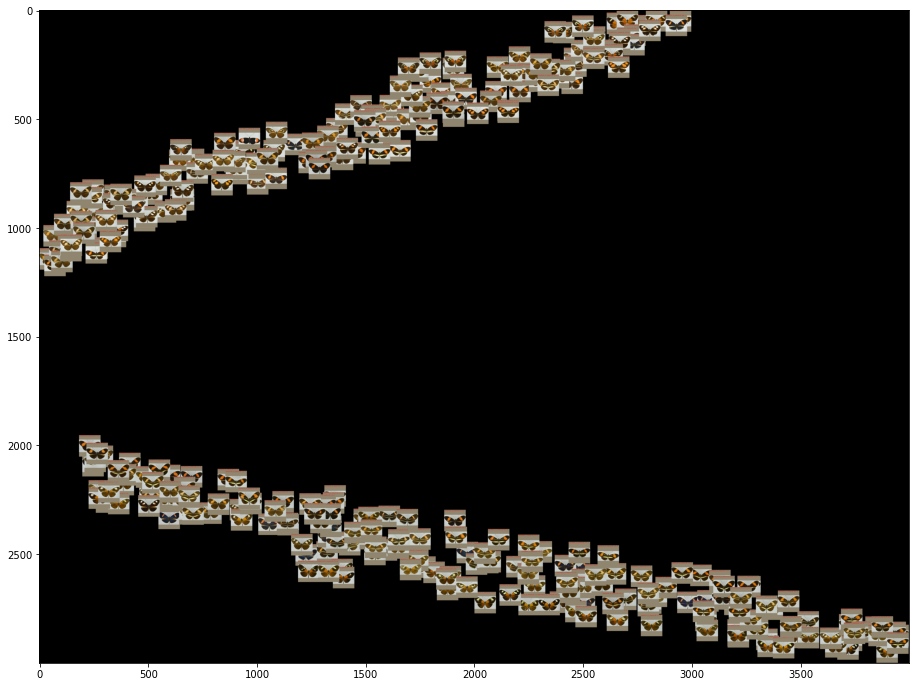

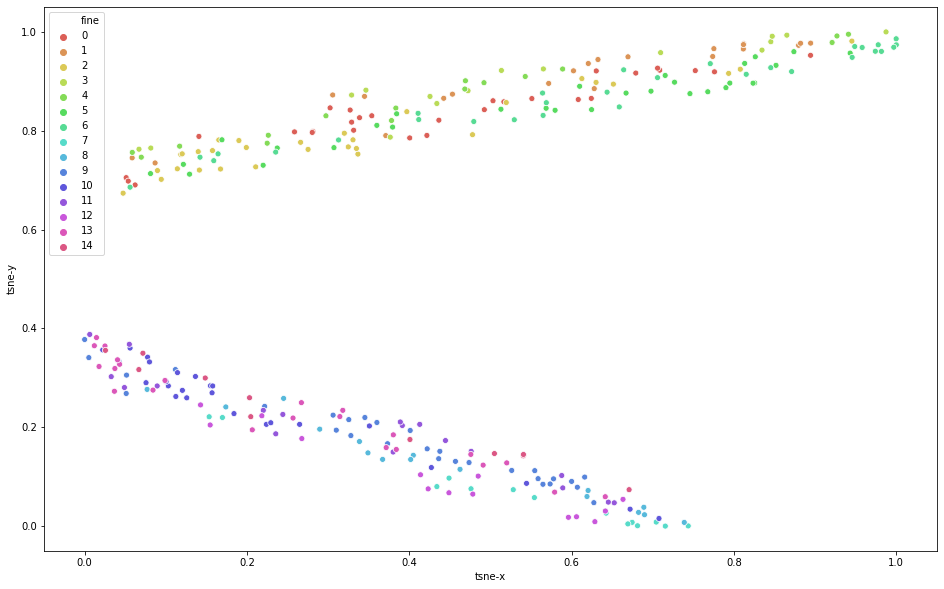

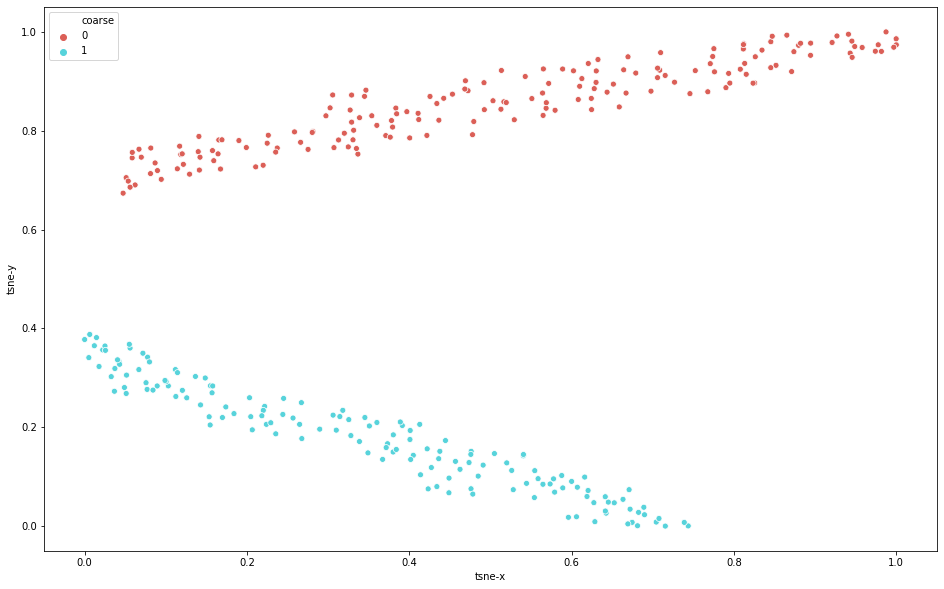

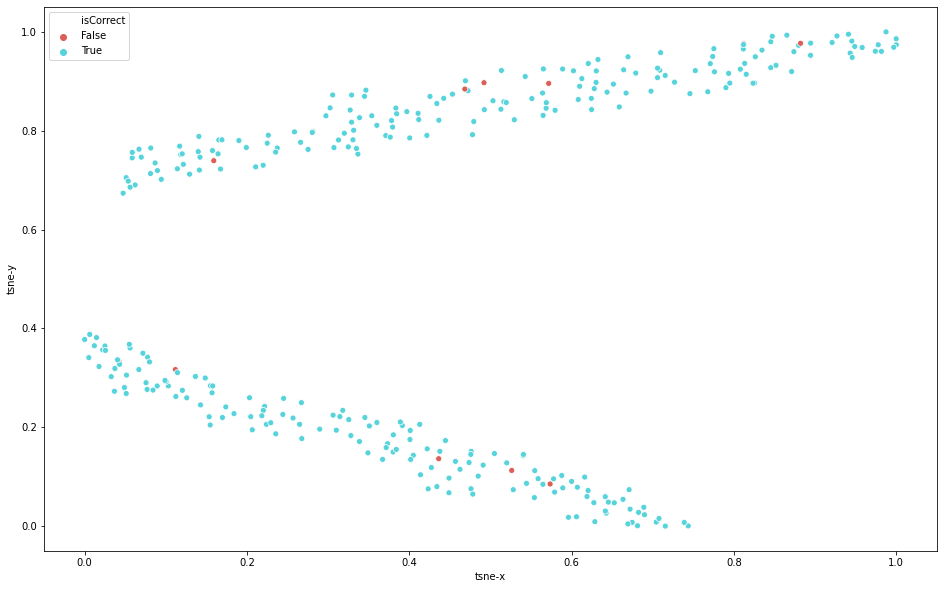

In [6]:
activation_layer = 'layer2'#'fine'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 81/81 [00:01<00:00, 79.91it/s] 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 27.789995
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 56.7798653, gradient norm = 0.5890386 (50 iterations in 0.089s)
[t-SNE] Iteration 100: error = 57.3071709, gradient norm = 0.5732657 (50 iterations in 0.101s)
[t-SNE] Iteration 150: error = 56.4107552, gradient norm = 0.5603010 (50 iterations in 0.107s)
[t-SNE] Iteration 200: error = 56.6522789, gradient norm = 0.5799926 (50 iterations in 0.095s)
[t-SNE] Iteration 250: error = 54.9498367, gradient norm = 0.6073465 (50 iterations in 0.109s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.949837
[t-SNE] Iteration 300: error = 0.2047799, gradient norm = 0.0016787 (50 iterations in 0.109s)
[t-SNE] Iteration 350: error = 0.1623020, gradient norm = 0.0011378 

100%|██████████| 81/81 [00:01<00:00, 77.85it/s] 


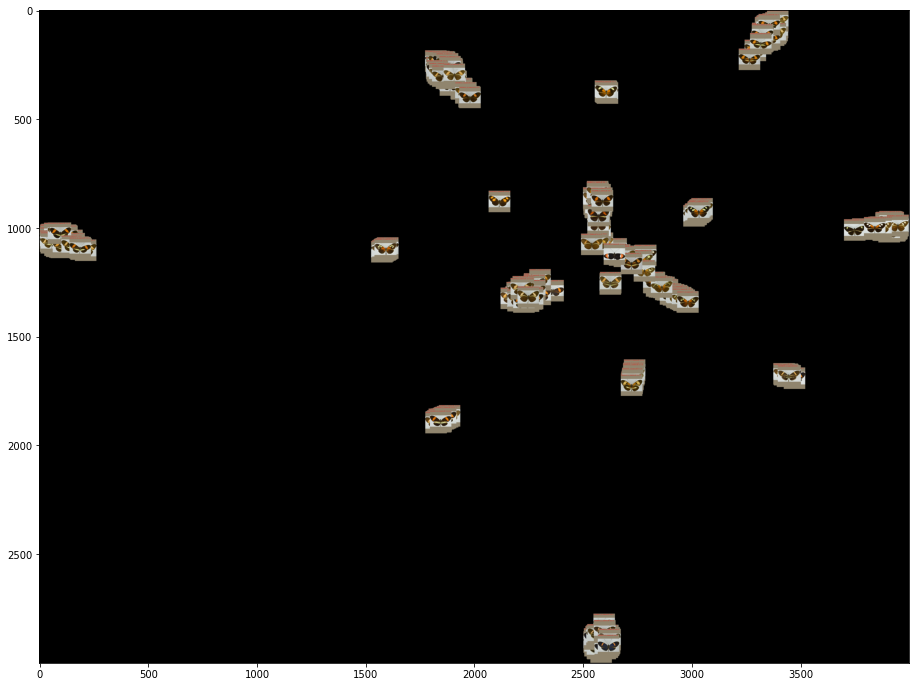

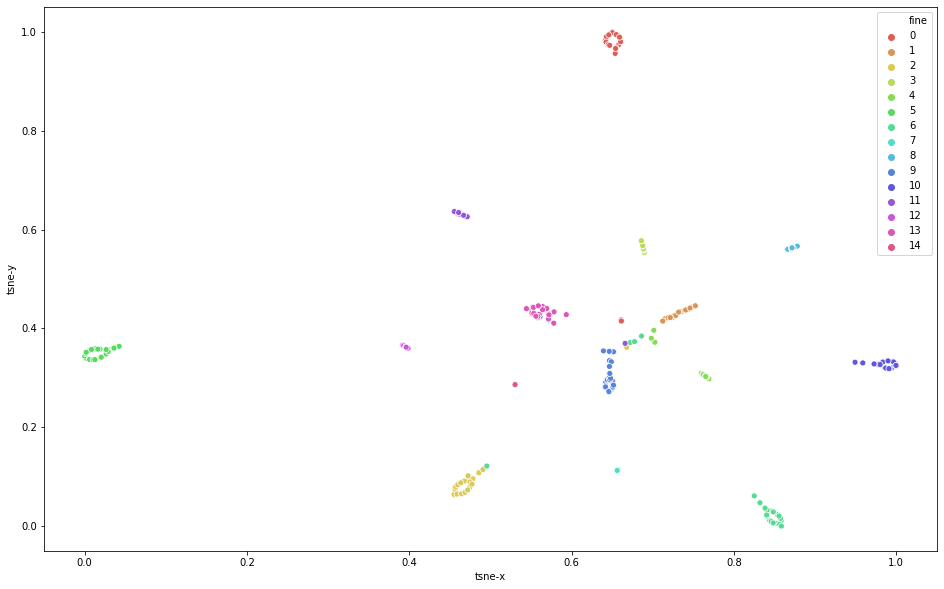

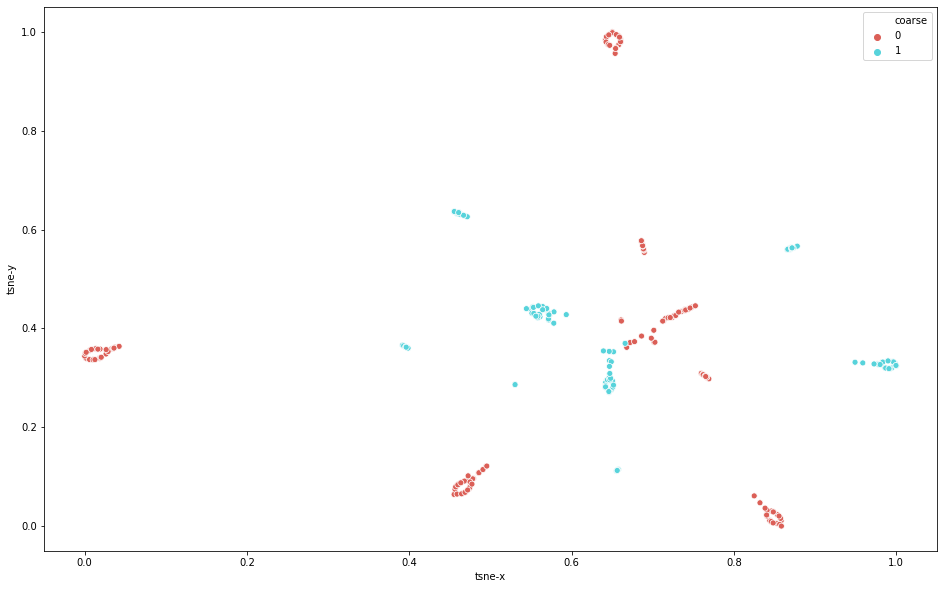

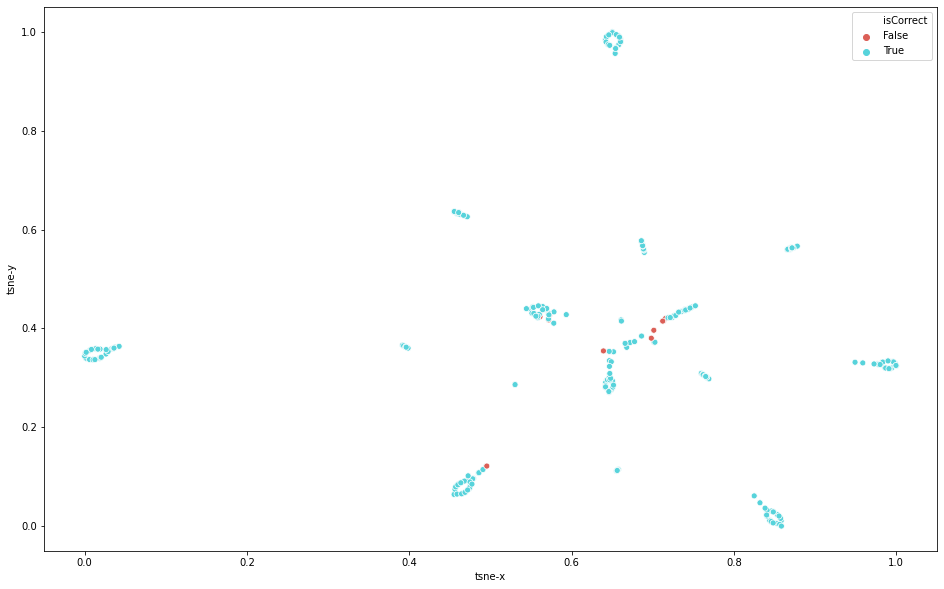

In [7]:
activation_layer = 'layer4'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)

100%|██████████| 81/81 [00:00<00:00, 81.28it/s] 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 4.341312
[t-SNE] Computed conditional probabilities in 0.020s
[t-SNE] Iteration 50: error = 56.9821663, gradient norm = 0.5730940 (50 iterations in 0.080s)
[t-SNE] Iteration 100: error = 56.6559792, gradient norm = 0.5296104 (50 iterations in 0.072s)
[t-SNE] Iteration 150: error = 52.4712257, gradient norm = 0.5892531 (50 iterations in 0.074s)
[t-SNE] Iteration 200: error = 53.4973412, gradient norm = 0.5753357 (50 iterations in 0.081s)
[t-SNE] Iteration 250: error = 54.0131798, gradient norm = 0.5793082 (50 iterations in 0.092s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.013180
[t-SNE] Iteration 300: error = 0.1473611, gradient norm = 0.0042312 (50 iterations in 0.124s)
[t-SNE] Iteration 350: error = 0.1310666, gradient norm = 0.0003404 (

100%|██████████| 81/81 [00:01<00:00, 77.99it/s] 


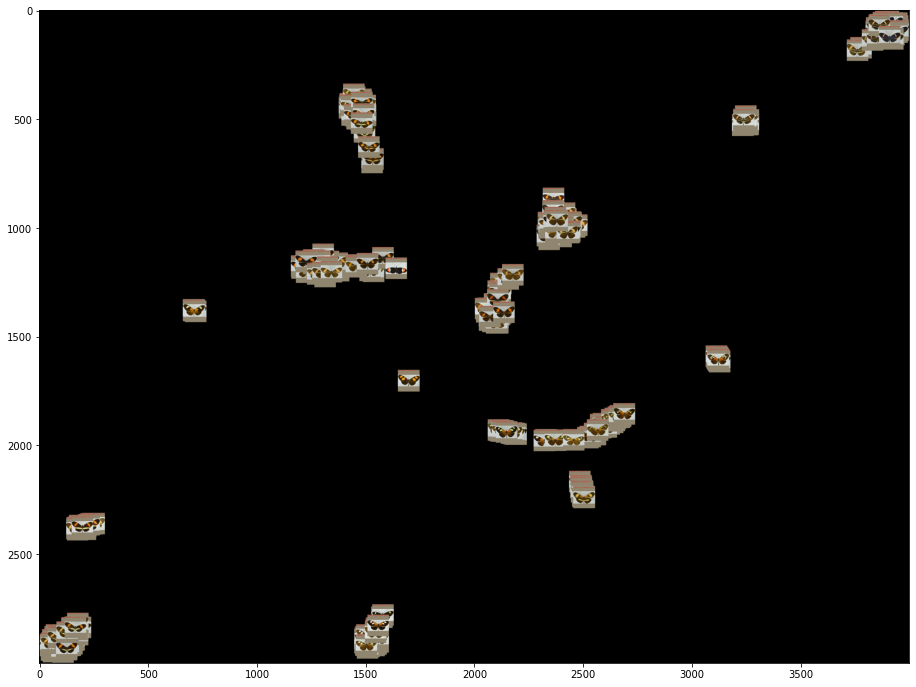

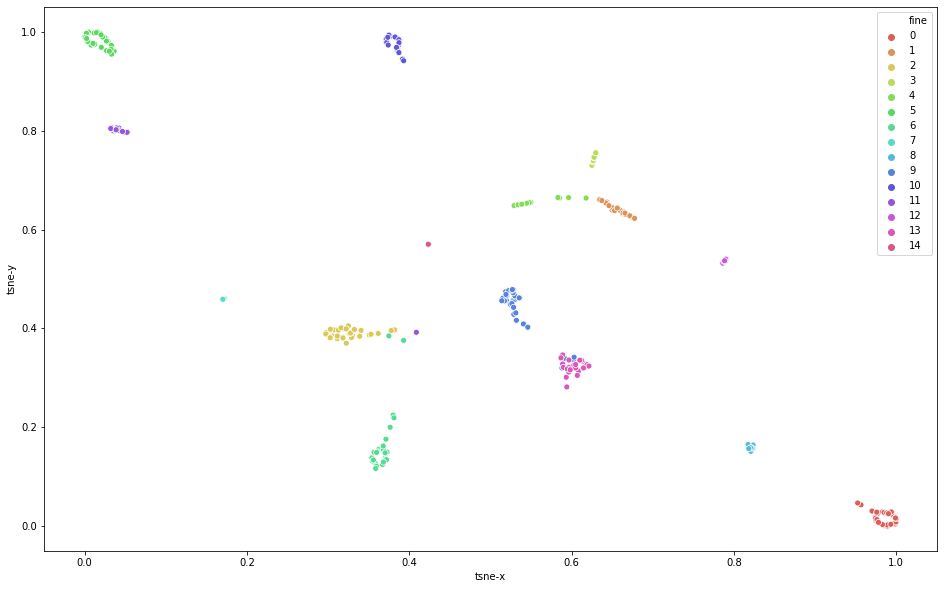

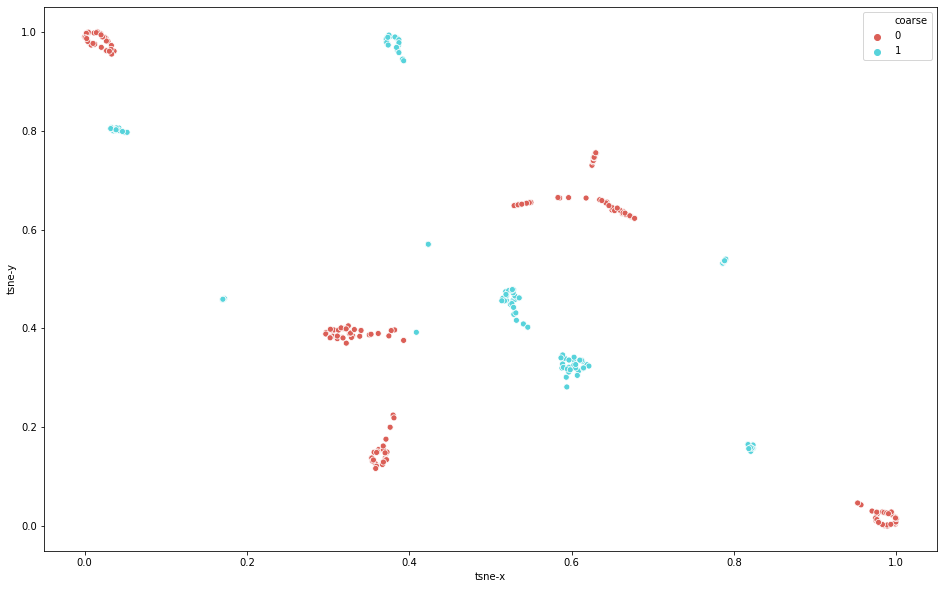

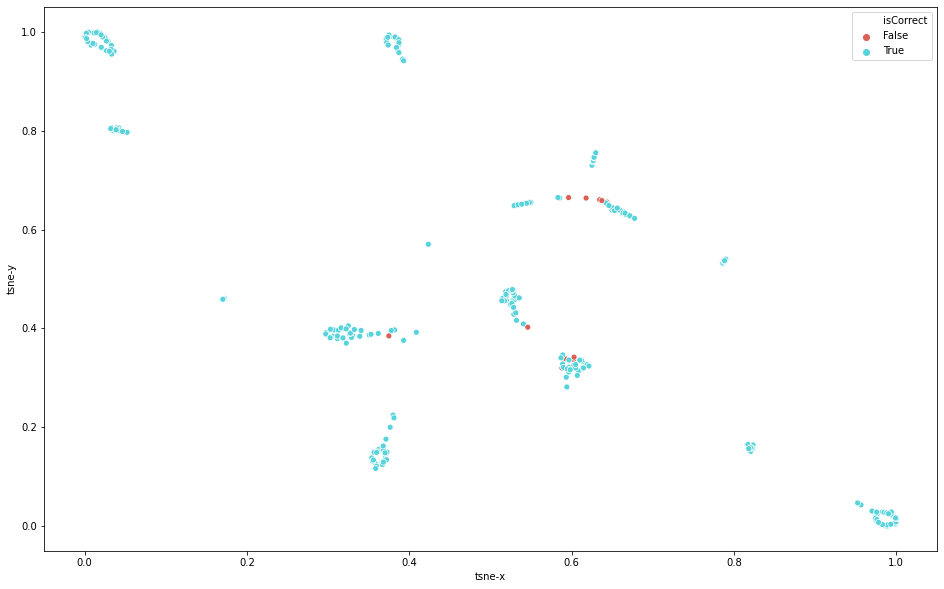

In [8]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                dataset_name+"_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, cuda)